# Machine Analysis

These notebooks look to analyse the time spent by each patient at the different machines. They use the geopandas package to capture the points in the polygons representing the different machines. They then look to capture the time spent in that machine.

## Package and Function Load In

In [ ]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [ ]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos

     |████████████████████████████████| 1.0 MB 6.8 MB/s 
     |████████████████████████████████| 6.3 MB 44.7 MB/s 
     |████████████████████████████████| 16.7 MB 196 kB/s 
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 2.1 MB 4.9 MB/s 


## File Load In

In this section you must load in the appropriate patient journey file for analysis.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.geometry import box
from shapely import wkt
import pandas as pd
import rtree
import pygeos
import geopandas as gpd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

dftest = pd.read_csv('phase3_all_to_20220311.csv')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Creating the Machine Polygon or MultiPolygon

The polygon coordinates are captured using the line_with_coordinates.html file. The polygon coordinates must be entered in the order of top left, bottom left, bottom right and then top right.

In [ ]:
WF_poly1 = Polygon([(30.8, 17.7), (30.8, 5.8), (33.3, 5.8), (33.3, 17.7)])

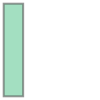

In [ ]:
WF_poly1

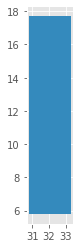

In [ ]:
 p = gpd.GeoSeries(WF_poly1)
 p.plot()
 plt.show()

## Data Cleaning and Formatting

In [ ]:
dftest = dftest.dropna()
dftest[['xlocation', 'ylocation']] = dftest['Location'].str.split(',', expand = True)

In [ ]:
dfG1221 = dftest.loc[dftest['Patient'] == 'G1221']

In [ ]:
column_list = list(dftest)
column_list

['Patient', 'Location', 'from', 'to', 'xlocation', 'ylocation']

## GeoPandas Dataframe Creation

This section creates a GeoPandas dataframeusing the coordinates from the patient journey dataset.

The next section creates a geometry using the polygon or MultiPolygon shape that was created earlier.

In [ ]:
gdf = gpd.GeoDataFrame(
    dftest, geometry=gpd.points_from_xy(dftest.xlocation, dftest.ylocation))

In [ ]:
gdf['Location'] = gdf['Location'].astype(str)

In [ ]:
WF_multipoly_gdf = gpd.GeoDataFrame(geometry  = gpd.GeoSeries(WF_poly1))

In [ ]:
WF_multipoly_gdf

,geometry
0,"POLYGON ((30.80000 17.70000, 30.80000 5.80000,..."


## Inner Join of the Two GeoPandas DataFrames

This section runs a spatial join of the two GeoDataframes it captures all of the points, in this example the patient journey points, that occur with in the polygon or MultiPolygon that was created earlier. This represents the time spent by the patient in the machine.

In [ ]:
AF_join = gpd.sjoin(gdf, WF_multipoly_gdf, how = 'inner')
AF_join

,Patient,Location,from,to,xlocation,ylocation,geometry,index_right
114,G2341,"30.955,13.646",07/03/2022 11:52,07/03/2022 11:52,30.955,13.646,POINT (30.95500 13.64600),0
115,G2341,"31.941,13.167",07/03/2022 11:52,07/03/2022 11:52,31.941,13.167,POINT (31.94100 13.16700),0
116,G2341,"32.918,13.516",07/03/2022 11:52,07/03/2022 11:52,32.918,13.516,POINT (32.91800 13.51600),0
117,G2341,"31.84,13.65",07/03/2022 11:52,07/03/2022 11:52,31.84,13.65,POINT (31.84000 13.65000),0
118,G2341,"32.918,13.516",07/03/2022 11:52,07/03/2022 11:52,32.918,13.516,POINT (32.91800 13.51600),0
...,...,...,...,...,...,...,...,...
16263,R2409,"31.452,16.953",09/03/2022 16:14,09/03/2022 16:14,31.452,16.953,POINT (31.45200 16.95300),0
16264,R2409,"32.694,16.919",09/03/2022 16:14,09/03/2022 16:14,32.694,16.919,POINT (32.69400 16.91900),0
16265,R2409,"31.692,16.598",09/03/2022 16:14,09/03/2022 16:14,31.692,16.598,POINT (31.69200 16.59800),0
16267,R2409,"32.694,16.919",09/03/2022 16:14,09/03/2022 16:15,32.694,16.919,POINT (32.69400 16.91900),0


## More data cleaning

## Setting up the data for analysis

This analysis now follows the code that was done in the phase 1, phase 2 and phase 3 notebooks. There are more detailed instructions in those notebooks.

The analysis and the outputs match the work done in those notebooks exactly from this point onwards.

In [ ]:
AF_join['newfrom'] = lookup(AF_join['from'], format='%d/%m/%Y %H:%M')
AF_join['newto'] = lookup(AF_join['to'], format='%d/%m/%Y %H:%M')

In [ ]:
dfgrouped = AF_join.groupby('Patient', as_index = False).agg({'newfrom': ['min'], 'newto': ['max']})

In [ ]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]+'_'+i[1])

In [ ]:
dfgrouped.columns = flat_cols

In [ ]:
dfgrouped = dfgrouped.rename(columns={'Patient_': 'Patient'})
dfgrouped = dfgrouped.rename(columns={'newfrom_min': 'newfrom'})
dfgrouped = dfgrouped.rename(columns={'newto_max': 'newto'})

In [ ]:
dfgrouped

,Patient,newfrom,newto
0,G2341,2022-03-07 11:52:00,2022-03-07 12:00:00
1,G2342,2022-03-07 11:18:00,2022-03-07 11:24:00
2,G2343,2022-03-07 10:54:00,2022-03-07 10:59:00
3,G2344,2022-03-07 11:31:00,2022-03-07 11:38:00
4,G2345,2022-03-07 11:07:00,2022-03-07 11:13:00
5,G2346,2022-03-07 11:05:00,2022-03-07 11:12:00
6,G2347,2022-03-07 11:55:00,2022-03-07 12:08:00
7,G2348,2022-03-07 11:15:00,2022-03-07 11:21:00
8,G2349,2022-03-07 11:36:00,2022-03-07 11:44:00
9,G2350,2022-03-07 11:58:00,2022-03-07 12:02:00


In [ ]:
dfgrouped['visit_length'] = dfgrouped['newto'] - dfgrouped['newfrom']

In [ ]:
dfgrouped['start_day'] = dfgrouped['newfrom'].dt.day
dfgrouped['end_day'] = dfgrouped['newto'].dt.day

In [ ]:
conditions = [dfgrouped['start_day'] == dfgrouped['end_day'], dfgrouped['start_day'] != dfgrouped['end_day']]
choices = ['equal', 'not_equal']
dfgrouped['sameday'] = np.select(conditions, choices)
dfgrouped['sameday'].unique()

array(['equal', 'not_equal'], dtype=object)

In [ ]:
dfgrouped = dfgrouped.drop(dfgrouped[dfgrouped.sameday == 'not_equal'].index)


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 00:17:00')

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday
0,G2341,2022-03-07 11:52:00,2022-03-07 12:00:00,0 days 00:08:00,7,7,equal
1,G2342,2022-03-07 11:18:00,2022-03-07 11:24:00,0 days 00:06:00,7,7,equal
2,G2343,2022-03-07 10:54:00,2022-03-07 10:59:00,0 days 00:05:00,7,7,equal
3,G2344,2022-03-07 11:31:00,2022-03-07 11:38:00,0 days 00:07:00,7,7,equal
4,G2345,2022-03-07 11:07:00,2022-03-07 11:13:00,0 days 00:06:00,7,7,equal
5,G2346,2022-03-07 11:05:00,2022-03-07 11:12:00,0 days 00:07:00,7,7,equal
6,G2347,2022-03-07 11:55:00,2022-03-07 12:08:00,0 days 00:13:00,7,7,equal
7,G2348,2022-03-07 11:15:00,2022-03-07 11:21:00,0 days 00:06:00,7,7,equal
8,G2349,2022-03-07 11:36:00,2022-03-07 11:44:00,0 days 00:08:00,7,7,equal
9,G2350,2022-03-07 11:58:00,2022-03-07 12:02:00,0 days 00:04:00,7,7,equal


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 00:17:00')

In [ ]:
dfgrouped['visit_length'].describe()

count                          179
mean     0 days 00:05:43.240223463
std      0 days 00:02:45.850221287
min                0 days 00:00:00
25%                0 days 00:04:00
50%                0 days 00:05:00
75%                0 days 00:07:00
max                0 days 00:17:00
Name: visit_length, dtype: object

In [ ]:
dfgrouped['dayofweek'] = dfgrouped['newfrom'].dt.day_name()
df_final= dfgrouped.dropna()

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G2341,2022-03-07 11:52:00,2022-03-07 12:00:00,0 days 00:08:00,7,7,equal,Monday
1,G2342,2022-03-07 11:18:00,2022-03-07 11:24:00,0 days 00:06:00,7,7,equal,Monday
2,G2343,2022-03-07 10:54:00,2022-03-07 10:59:00,0 days 00:05:00,7,7,equal,Monday
3,G2344,2022-03-07 11:31:00,2022-03-07 11:38:00,0 days 00:07:00,7,7,equal,Monday
4,G2345,2022-03-07 11:07:00,2022-03-07 11:13:00,0 days 00:06:00,7,7,equal,Monday
5,G2346,2022-03-07 11:05:00,2022-03-07 11:12:00,0 days 00:07:00,7,7,equal,Monday
6,G2347,2022-03-07 11:55:00,2022-03-07 12:08:00,0 days 00:13:00,7,7,equal,Monday
7,G2348,2022-03-07 11:15:00,2022-03-07 11:21:00,0 days 00:06:00,7,7,equal,Monday
8,G2349,2022-03-07 11:36:00,2022-03-07 11:44:00,0 days 00:08:00,7,7,equal,Monday
9,G2350,2022-03-07 11:58:00,2022-03-07 12:02:00,0 days 00:04:00,7,7,equal,Monday


In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G2341,2022-03-07 11:52:00,2022-03-07 12:00:00,0 days 00:08:00,7,7,equal,Monday
1,G2342,2022-03-07 11:18:00,2022-03-07 11:24:00,0 days 00:06:00,7,7,equal,Monday
2,G2343,2022-03-07 10:54:00,2022-03-07 10:59:00,0 days 00:05:00,7,7,equal,Monday
3,G2344,2022-03-07 11:31:00,2022-03-07 11:38:00,0 days 00:07:00,7,7,equal,Monday
4,G2345,2022-03-07 11:07:00,2022-03-07 11:13:00,0 days 00:06:00,7,7,equal,Monday
5,G2346,2022-03-07 11:05:00,2022-03-07 11:12:00,0 days 00:07:00,7,7,equal,Monday
6,G2347,2022-03-07 11:55:00,2022-03-07 12:08:00,0 days 00:13:00,7,7,equal,Monday
7,G2348,2022-03-07 11:15:00,2022-03-07 11:21:00,0 days 00:06:00,7,7,equal,Monday
8,G2349,2022-03-07 11:36:00,2022-03-07 11:44:00,0 days 00:08:00,7,7,equal,Monday
9,G2350,2022-03-07 11:58:00,2022-03-07 12:02:00,0 days 00:04:00,7,7,equal,Monday


In [ ]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
def ftod(x):
    if (x>13):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

In [ ]:
df_final['tod'] = df_final.newfrom.dt.hour.map(ftod) 

In [ ]:
timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)

In [ ]:
timeofdaymean

tod
afternoon   0 days 00:05:37.215189873
morning               0 days 00:05:48
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)

In [ ]:
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 00:06:32.195121951
Tuesday,0 days 00:05:29.230769230
Wednesday,0 days 00:05:16.875000
Thursday,0 days 00:05:14.594594594
Friday,0 days 00:05:58
Saturday,NaT
Sunday,NaT


In [ ]:
print('Monday')
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
print(Monday_count)

print('Tuesday')
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
print(Tuesday_count)

print('Wednesday')
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
print(Wednesday_count)

print('Thursday')
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
print(Thursday_count)

print('Friday')
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
print(Friday_count)

print('Saturday')
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
print(Saturday_count)

print('Sunday')
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()
print(Sunday_count)

Monday
41
Tuesday
39
Wednesday
32
Thursday
37
Friday
30
Saturday
0
Sunday
0


In [ ]:
weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}
weekday_df = pd.DataFrame(weekday_data)

In [ ]:
df_final['hour'] = df_final['newfrom'].dt.hour

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour
0,G2341,2022-03-07 11:52:00,2022-03-07 12:00:00,0 days 00:08:00,7,7,equal,Monday,morning,11
1,G2342,2022-03-07 11:18:00,2022-03-07 11:24:00,0 days 00:06:00,7,7,equal,Monday,morning,11
2,G2343,2022-03-07 10:54:00,2022-03-07 10:59:00,0 days 00:05:00,7,7,equal,Monday,morning,10
3,G2344,2022-03-07 11:31:00,2022-03-07 11:38:00,0 days 00:07:00,7,7,equal,Monday,morning,11
4,G2345,2022-03-07 11:07:00,2022-03-07 11:13:00,0 days 00:06:00,7,7,equal,Monday,morning,11
5,G2346,2022-03-07 11:05:00,2022-03-07 11:12:00,0 days 00:07:00,7,7,equal,Monday,morning,11
6,G2347,2022-03-07 11:55:00,2022-03-07 12:08:00,0 days 00:13:00,7,7,equal,Monday,morning,11
7,G2348,2022-03-07 11:15:00,2022-03-07 11:21:00,0 days 00:06:00,7,7,equal,Monday,morning,11
8,G2349,2022-03-07 11:36:00,2022-03-07 11:44:00,0 days 00:08:00,7,7,equal,Monday,morning,11
9,G2350,2022-03-07 11:58:00,2022-03-07 12:02:00,0 days 00:04:00,7,7,equal,Monday,morning,11


In [ ]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)

In [ ]:
hourlymean

hour
10             0 days 00:04:24
11      0 days 00:06:21.600000
12   0 days 00:05:24.444444444
13             0 days 00:06:15
14      0 days 00:05:24.375000
15   0 days 00:05:14.594594594
16             0 days 00:07:42
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_final.dtypes

Patient                  object
newfrom          datetime64[ns]
newto            datetime64[ns]
visit_length    timedelta64[ns]
start_day                 int64
end_day                   int64
sameday                  object
dayofweek                object
tod                      object
hour                      int64
dtype: object

In [ ]:
print('Nine')
nine_count = df_final['hour'][df_final['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_final['hour'][df_final['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_final['hour'][df_final['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_final['hour'][df_final['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_final['hour'][df_final['hour']==13].count()
print(one_count)

print('Two')
two_count = df_final['hour'][df_final['hour']==14].count()
print(two_count)

print('Three')
three_count = df_final['hour'][df_final['hour']==15].count()
print(three_count)

print('Four')
four_count = df_final['hour'][df_final['hour']==16].count()
print(four_count)

Nine
0
Ten
15
Eleven
50
Twelve
27
One
8
Two
32
Three
37
Four
10


In [ ]:
df_final['condition'] = df_final['Patient'].str[0]

In [ ]:
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)

In [ ]:
conditionmean

condition
G   0 days 00:06:21.346153846
R      0 days 00:04:50.400000
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
print('Glaucoma')
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
print(glaucoma_count)

print('Medical Retinal')
retina_count = df_final['condition'][df_final['condition']=='R'].count()
print(retina_count)

Glaucoma
104
Medical Retinal
75


In [ ]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)

In [ ]:
df_final['visit_length_minutes'] = df_final['visit_length_minutes'] / 60

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G2341,2022-03-07 11:52:00,2022-03-07 12:00:00,0 days 00:08:00,7,7,equal,Monday,morning,11,G,8.0000
1,G2342,2022-03-07 11:18:00,2022-03-07 11:24:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
2,G2343,2022-03-07 10:54:00,2022-03-07 10:59:00,0 days 00:05:00,7,7,equal,Monday,morning,10,G,5.0000
3,G2344,2022-03-07 11:31:00,2022-03-07 11:38:00,0 days 00:07:00,7,7,equal,Monday,morning,11,G,7.0000
4,G2345,2022-03-07 11:07:00,2022-03-07 11:13:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
5,G2346,2022-03-07 11:05:00,2022-03-07 11:12:00,0 days 00:07:00,7,7,equal,Monday,morning,11,G,7.0000
6,G2347,2022-03-07 11:55:00,2022-03-07 12:08:00,0 days 00:13:00,7,7,equal,Monday,morning,11,G,13.0000
7,G2348,2022-03-07 11:15:00,2022-03-07 11:21:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
8,G2349,2022-03-07 11:36:00,2022-03-07 11:44:00,0 days 00:08:00,7,7,equal,Monday,morning,11,G,8.0000
9,G2350,2022-03-07 11:58:00,2022-03-07 12:02:00,0 days 00:04:00,7,7,equal,Monday,morning,11,G,4.0000


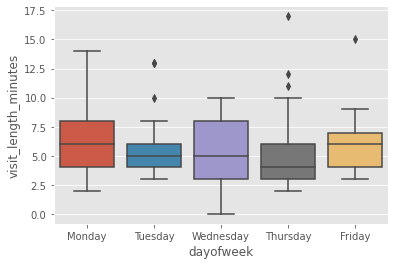

In [ ]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_final)

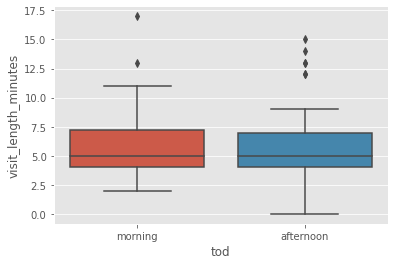

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

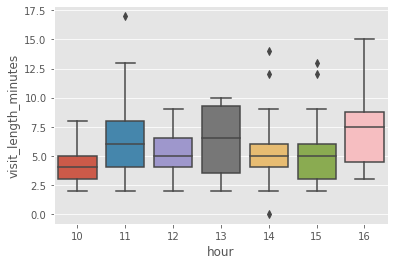

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

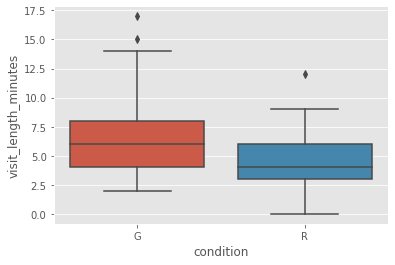

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

In [ ]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)]
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 166
newfrom                 166
newto                   166
visit_length            166
start_day               166
end_day                 166
sameday                 166
dayofweek               166
tod                     166
hour                    166
condition               166
visit_length_minutes    166
dtype: int64


In [ ]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G2341,2022-03-07 11:52:00,2022-03-07 12:00:00,0 days 00:08:00,7,7,equal,Monday,morning,11,G,8.0000
1,G2342,2022-03-07 11:18:00,2022-03-07 11:24:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
2,G2343,2022-03-07 10:54:00,2022-03-07 10:59:00,0 days 00:05:00,7,7,equal,Monday,morning,10,G,5.0000
3,G2344,2022-03-07 11:31:00,2022-03-07 11:38:00,0 days 00:07:00,7,7,equal,Monday,morning,11,G,7.0000
4,G2345,2022-03-07 11:07:00,2022-03-07 11:13:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
5,G2346,2022-03-07 11:05:00,2022-03-07 11:12:00,0 days 00:07:00,7,7,equal,Monday,morning,11,G,7.0000
6,G2347,2022-03-07 11:55:00,2022-03-07 12:08:00,0 days 00:13:00,7,7,equal,Monday,morning,11,G,13.0000
7,G2348,2022-03-07 11:15:00,2022-03-07 11:21:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
8,G2349,2022-03-07 11:36:00,2022-03-07 11:44:00,0 days 00:08:00,7,7,equal,Monday,morning,11,G,8.0000
9,G2350,2022-03-07 11:58:00,2022-03-07 12:02:00,0 days 00:04:00,7,7,equal,Monday,morning,11,G,4.0000


In [ ]:
mean = df_outliers['visit_length_minutes'].mean()
print(mean)
print(df_nozero['visit_length_minutes'].mean())

5.556818181818182
5.588571428571429


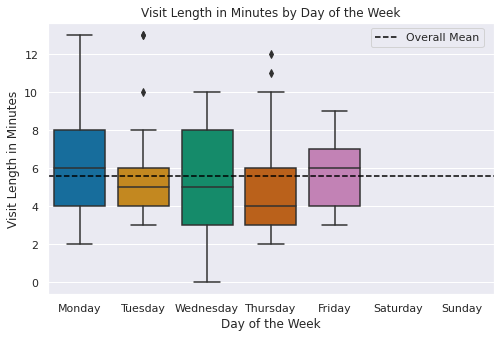

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated.png', bbox_inches='tight')

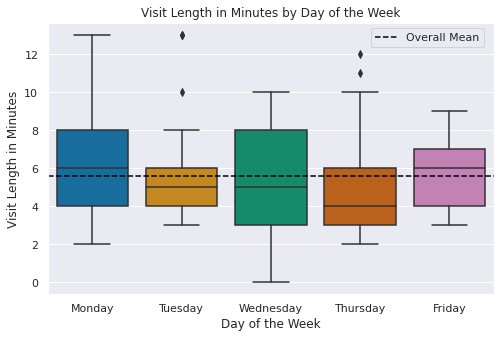

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated_noweekend.png', bbox_inches='tight')

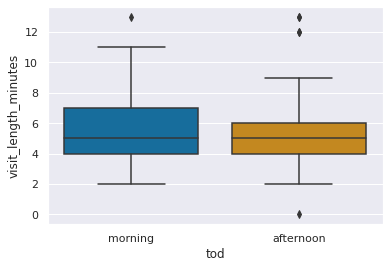

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

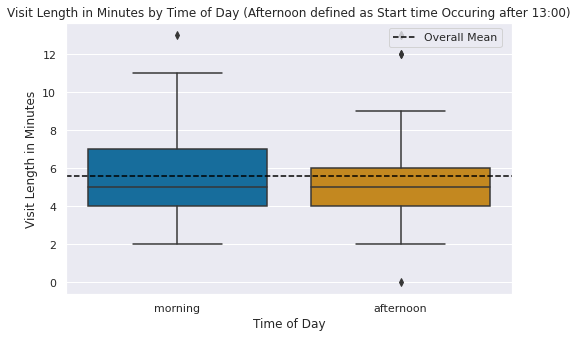

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Time of Day (Afternoon defined as Start time Occuring after 13:00)')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('timeofday_updated.png', bbox_inches='tight')

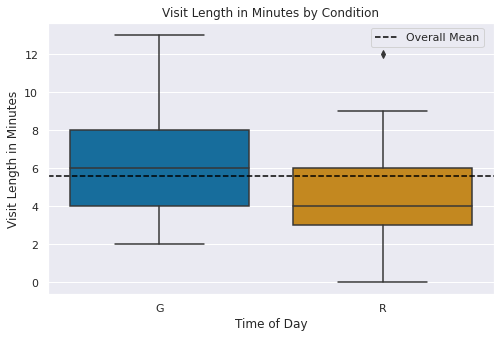

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Condition')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('condition_updated.png', bbox_inches='tight')

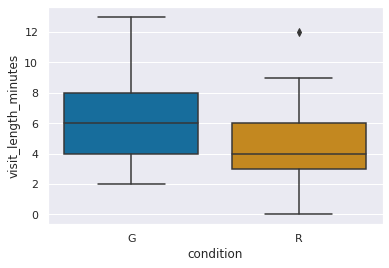

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

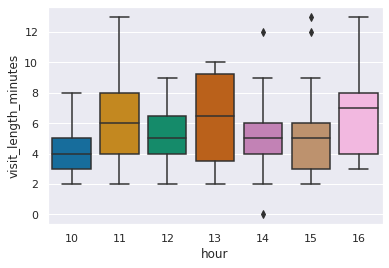

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

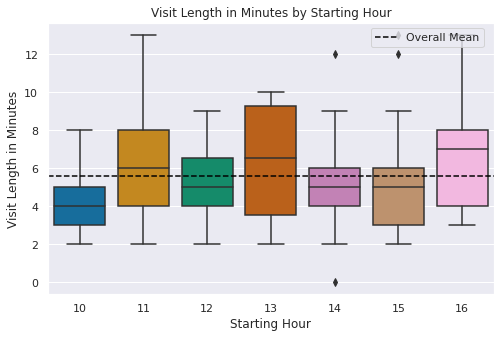

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Starting Hour')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('hour_updated.png', bbox_inches='tight')

In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df_outliers['visit_length_minutes'].describe()

count                                   176.0000
mean                                      5.5568
std                                       2.4767
min                                       0.0000
25%                                       4.0000
50%                                       5.0000
75%                                       7.0000
max                                      13.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].describe()

count                                   179.0000
mean                                      5.7207
std                                       2.7642
min                                       0.0000
25%                                       4.0000
50%                                       5.0000
75%                                       7.0000
max                                      17.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].median()

5.0

In [ ]:
df_outliers['visit_length'].describe()

count                          176
mean     0 days 00:05:33.409090909
std      0 days 00:02:28.600221985
min                0 days 00:00:00
25%                0 days 00:04:00
50%                0 days 00:05:00
75%                0 days 00:07:00
max                0 days 00:13:00
Name: visit_length, dtype: object

In [ ]:
df_final['visit_length'].describe()

count                          179
mean     0 days 00:05:43.240223463
std      0 days 00:02:45.850221287
min                0 days 00:00:00
25%                0 days 00:04:00
50%                0 days 00:05:00
75%                0 days 00:07:00
max                0 days 00:17:00
Name: visit_length, dtype: object

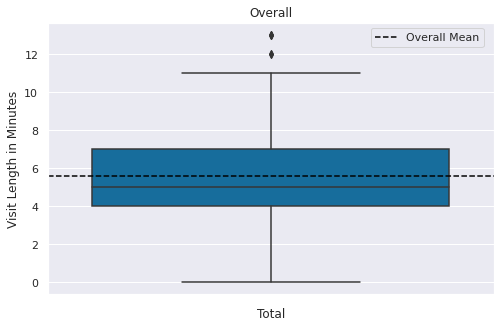

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)
svm.set_title('Overall')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('tested.png', bbox_inches='tight')

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
15
Eleven
49
Twelve
27
One
8
Two
31
Three
37
Four
9


In [ ]:
print('Monday Outlier')
mondayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Monday'].count()
print(mondayoutlier)

print('Tuesday Outlier')
tuesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Tuesday'].count()
print(tuesdayoutlier)

print('Wednesday Outlier')
wednesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Wednesday'].count()
print(wednesdayoutlier)

print('Thursday Outlier')
thursdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Thursday'].count()
print(thursdayoutlier)

print('Friday Outlier')
fridayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Friday'].count()
print(fridayoutlier)

print('Saturday Outlier')
saturdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Saturday'].count()
print(saturdayoutlier)

print('Sunday Outlier')
sundayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Sunday'].count()
print(sundayoutlier)

Monday Outlier
40
Tuesday Outlier
39
Wednesday Outlier
32
Thursday Outlier
36
Friday Outlier
29
Saturday Outlier
0
Sunday Outlier
0


In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length_minutes'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
dayoftheweekmean

dayofweek
Monday                                        6.3500
Tuesday                                       5.4872
Wednesday                                     5.2812
Thursday                                      4.9167
Friday                                        5.6552
Saturday                                         NaN
Sunday                                           NaN
Name: visit_length_minutes, dtype: float64

In [ ]:
print('G')
glaucomacount = df_outliers['condition'][df_outliers['condition']=='G'].count()
print(glaucomacount)

print('R')
rcount = df_outliers['condition'][df_outliers['condition']=='R'].count()
print(rcount)

G
101
R
75


In [ ]:
conditionmean = df_outliers.groupby('condition')['visit_length_minutes'].mean(numeric_only=False)
conditionmean

condition
G                                     6.0891
R                                     4.8400
Name: visit_length_minutes, dtype: float64

In [ ]:
print('morning')
morningcount = df_outliers['tod'][df_outliers['tod']=='morning'].count()
print(morningcount)

print('afternoon')
afternooncount = df_outliers['tod'][df_outliers['tod']=='afternoon'].count()
print(afternooncount)

morning
99
afternoon
77


In [ ]:
todmean = df_outliers.groupby('tod')['visit_length_minutes'].mean(numeric_only=False)
todmean

tod
afternoon                                     5.3896
morning                                       5.6869
Name: visit_length_minutes, dtype: float64

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
15
Eleven
49
Twelve
27
One
8
Two
31
Three
37
Four
9


In [ ]:
hourmean = df_outliers.groupby('hour')['visit_length_minutes'].mean(numeric_only=False)
hourmean

hour
10                                     4.4000
11                                     6.1429
12                                     5.4074
13                                     6.2500
14                                     5.1290
15                                     5.2432
16                                     6.8889
Name: visit_length_minutes, dtype: float64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count()

Patient                 166
newfrom                 166
newto                   166
visit_length            166
start_day               166
end_day                 166
sameday                 166
dayofweek               166
tod                     166
hour                    166
condition               166
visit_length_minutes    166
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] == 0).all(axis=1)].count()

Patient                 1
newfrom                 1
newto                   1
visit_length            1
start_day               1
end_day                 1
sameday                 1
dayofweek               1
tod                     1
hour                    1
condition               1
visit_length_minutes    1
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length']]).all(axis=1)].count()

Patient                 175
newfrom                 175
newto                   175
visit_length            175
start_day               175
end_day                 175
sameday                 175
dayofweek               175
tod                     175
hour                    175
condition               175
visit_length_minutes    175
dtype: int64

In [ ]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
144,R1580,2022-03-09 14:08:00,2022-03-09 14:08:00,0 days 00:00:00,9,9,equal,Wednesday,afternoon,14,R,0.0000
20,G2361,2022-03-07 15:00:00,2022-03-07 15:02:00,0 days 00:02:00,7,7,equal,Monday,afternoon,15,G,2.0000
49,G2391,2022-03-09 10:57:00,2022-03-09 10:59:00,0 days 00:02:00,9,9,equal,Wednesday,morning,10,G,2.0000
59,G2402,2022-03-09 13:57:00,2022-03-09 13:59:00,0 days 00:02:00,9,9,equal,Wednesday,morning,13,G,2.0000
65,G2408,2022-03-09 15:22:00,2022-03-09 15:24:00,0 days 00:02:00,9,9,equal,Wednesday,afternoon,15,G,2.0000


In [ ]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
144,R1580,2022-03-09 14:08:00,2022-03-09 14:08:00,0 days 00:00:00,9,9,equal,Wednesday,afternoon,14,R,0.0000
20,G2361,2022-03-07 15:00:00,2022-03-07 15:02:00,0 days 00:02:00,7,7,equal,Monday,afternoon,15,G,2.0000
49,G2391,2022-03-09 10:57:00,2022-03-09 10:59:00,0 days 00:02:00,9,9,equal,Wednesday,morning,10,G,2.0000
59,G2402,2022-03-09 13:57:00,2022-03-09 13:59:00,0 days 00:02:00,9,9,equal,Wednesday,morning,13,G,2.0000
65,G2408,2022-03-09 15:22:00,2022-03-09 15:24:00,0 days 00:02:00,9,9,equal,Wednesday,afternoon,15,G,2.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
6,G2347,2022-03-07 11:55:00,2022-03-07 12:08:00,0 days 00:13:00,7,7,equal,Monday,morning,11,G,13.0000
42,G2384,2022-03-08 15:08:00,2022-03-08 15:21:00,0 days 00:13:00,8,8,equal,Tuesday,afternoon,15,G,13.0000
45,G2387,2022-03-08 16:12:00,2022-03-08 16:25:00,0 days 00:13:00,8,8,equal,Tuesday,afternoon,16,G,13.0000
78,G2423,2022-03-10 15:24:00,2022-03-10 15:36:00,0 days 00:12:00,10,10,equal,Thursday,afternoon,15,G,12.0000
114,R1546,2022-03-07 14:16:00,2022-03-07 14:28:00,0 days 00:12:00,7,7,equal,Monday,afternoon,14,R,12.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
6,G2347,2022-03-07 11:55:00,2022-03-07 12:08:00,0 days 00:13:00,7,7,equal,Monday,morning,11,G,13.0000
42,G2384,2022-03-08 15:08:00,2022-03-08 15:21:00,0 days 00:13:00,8,8,equal,Tuesday,afternoon,15,G,13.0000
45,G2387,2022-03-08 16:12:00,2022-03-08 16:25:00,0 days 00:13:00,8,8,equal,Tuesday,afternoon,16,G,13.0000
78,G2423,2022-03-10 15:24:00,2022-03-10 15:36:00,0 days 00:12:00,10,10,equal,Thursday,afternoon,15,G,12.0000
114,R1546,2022-03-07 14:16:00,2022-03-07 14:28:00,0 days 00:12:00,7,7,equal,Monday,afternoon,14,R,12.0000


In [ ]:
df_final.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
70,G2414,2022-03-10 11:51:00,2022-03-10 12:08:00,0 days 00:17:00,10,10,equal,Thursday,morning,11,G,17.0000
103,G2451,2022-03-11 16:08:00,2022-03-11 16:23:00,0 days 00:15:00,11,11,equal,Friday,afternoon,16,G,15.0000
18,G2359,2022-03-07 14:49:00,2022-03-07 15:03:00,0 days 00:14:00,7,7,equal,Monday,afternoon,14,G,14.0000
6,G2347,2022-03-07 11:55:00,2022-03-07 12:08:00,0 days 00:13:00,7,7,equal,Monday,morning,11,G,13.0000
42,G2384,2022-03-08 15:08:00,2022-03-08 15:21:00,0 days 00:13:00,8,8,equal,Tuesday,afternoon,15,G,13.0000
45,G2387,2022-03-08 16:12:00,2022-03-08 16:25:00,0 days 00:13:00,8,8,equal,Tuesday,afternoon,16,G,13.0000
78,G2423,2022-03-10 15:24:00,2022-03-10 15:36:00,0 days 00:12:00,10,10,equal,Thursday,afternoon,15,G,12.0000
114,R1546,2022-03-07 14:16:00,2022-03-07 14:28:00,0 days 00:12:00,7,7,equal,Monday,afternoon,14,R,12.0000
67,G2411,2022-03-10 11:51:00,2022-03-10 12:02:00,0 days 00:11:00,10,10,equal,Thursday,morning,11,G,11.0000
13,G2354,2022-03-07 13:13:00,2022-03-07 13:23:00,0 days 00:10:00,7,7,equal,Monday,morning,13,G,10.0000


In [ ]:
df_outliers.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
6,G2347,2022-03-07 11:55:00,2022-03-07 12:08:00,0 days 00:13:00,7,7,equal,Monday,morning,11,G,13.0000
42,G2384,2022-03-08 15:08:00,2022-03-08 15:21:00,0 days 00:13:00,8,8,equal,Tuesday,afternoon,15,G,13.0000
45,G2387,2022-03-08 16:12:00,2022-03-08 16:25:00,0 days 00:13:00,8,8,equal,Tuesday,afternoon,16,G,13.0000
78,G2423,2022-03-10 15:24:00,2022-03-10 15:36:00,0 days 00:12:00,10,10,equal,Thursday,afternoon,15,G,12.0000
114,R1546,2022-03-07 14:16:00,2022-03-07 14:28:00,0 days 00:12:00,7,7,equal,Monday,afternoon,14,R,12.0000
67,G2411,2022-03-10 11:51:00,2022-03-10 12:02:00,0 days 00:11:00,10,10,equal,Thursday,morning,11,G,11.0000
13,G2354,2022-03-07 13:13:00,2022-03-07 13:23:00,0 days 00:10:00,7,7,equal,Monday,morning,13,G,10.0000
34,G2376,2022-03-08 13:52:00,2022-03-08 14:02:00,0 days 00:10:00,8,8,equal,Tuesday,morning,13,G,10.0000
48,G2390,2022-03-09 11:11:00,2022-03-09 11:21:00,0 days 00:10:00,9,9,equal,Wednesday,morning,11,G,10.0000
69,G2413,2022-03-10 11:31:00,2022-03-10 11:41:00,0 days 00:10:00,10,10,equal,Thursday,morning,11,G,10.0000


In [ ]:
df_outliers

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G2341,2022-03-07 11:52:00,2022-03-07 12:00:00,0 days 00:08:00,7,7,equal,Monday,morning,11,G,8.0000
1,G2342,2022-03-07 11:18:00,2022-03-07 11:24:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
2,G2343,2022-03-07 10:54:00,2022-03-07 10:59:00,0 days 00:05:00,7,7,equal,Monday,morning,10,G,5.0000
3,G2344,2022-03-07 11:31:00,2022-03-07 11:38:00,0 days 00:07:00,7,7,equal,Monday,morning,11,G,7.0000
4,G2345,2022-03-07 11:07:00,2022-03-07 11:13:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
5,G2346,2022-03-07 11:05:00,2022-03-07 11:12:00,0 days 00:07:00,7,7,equal,Monday,morning,11,G,7.0000
6,G2347,2022-03-07 11:55:00,2022-03-07 12:08:00,0 days 00:13:00,7,7,equal,Monday,morning,11,G,13.0000
7,G2348,2022-03-07 11:15:00,2022-03-07 11:21:00,0 days 00:06:00,7,7,equal,Monday,morning,11,G,6.0000
8,G2349,2022-03-07 11:36:00,2022-03-07 11:44:00,0 days 00:08:00,7,7,equal,Monday,morning,11,G,8.0000
9,G2350,2022-03-07 11:58:00,2022-03-07 12:02:00,0 days 00:04:00,7,7,equal,Monday,morning,11,G,4.0000


In [ ]:
df_outliers.loc[df_outliers['Patient'] == 'G1846']

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes


## CSV Creation

This creates a csv of the dataframe so that it can potentially be used in subsequent analysis.

In [ ]:
df_outliers['clinic_location'] = 'WF'
WFdf = df_outliers[['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes', 'clinic_location']].copy()
WFdf.to_csv('WFdf_phase3.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
